# Quantum Natural Gradient optimize

The Quantum Natural Gradient 

In [1]:
import torch
from torch.utils.data import random_split
import random
import matplotlib.pyplot as plt

import qadence as qd
from qadence_libs.qinfo_tools import QNG, QNG_SPSA

# Ensure reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)

# Number of qubits
n_qubits = 4

In [2]:
def qcl_training_data(
    domain: tuple = (0, 2 * torch.pi), n_points: int = 200
) -> tuple[torch.Tensor, torch.Tensor]:
    start, end = domain

    x_rand, _ = torch.sort(torch.DoubleTensor(n_points).uniform_(start, end))
    y_rand = torch.sin(x_rand)

    return x_rand, y_rand


x, y = qcl_training_data()

In [3]:
# random train/test split of the dataset
train_subset, test_subset = random_split(x, [0.75, 0.25])
train_ind = sorted(train_subset.indices)
test_ind = sorted(test_subset.indices)

x_train, y_train = x[train_ind], y[train_ind]
x_test, y_test = x[test_ind], y[test_ind]

In [4]:
# create a simple feature map to encode the input data
feature_param = qd.FeatureParameter("phi")
feature_map = qd.kron(qd.RX(i, feature_param) for i in range(n_qubits))
feature_map = qd.tag(feature_map, "feature_map")

# create a digital-analog variational ansatz using Qadence convenience constructors
ansatz = qd.hea(n_qubits, depth=n_qubits)
ansatz = qd.tag(ansatz, "ansatz")

# Observable
observable = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)

In [5]:
# Create separate circuits and models for each optimizer
circuit_adam = qd.QuantumCircuit(n_qubits, feature_map, ansatz)
circuit_qng = qd.QuantumCircuit(n_qubits, feature_map, ansatz)
circuit_qng_spsa = qd.QuantumCircuit(n_qubits, feature_map, ansatz)

model_adam = qd.QNN(circuit_adam, [observable])
model_qng = qd.QNN(circuit_qng, [observable])
model_qng_spsa = qd.QNN(circuit_qng_spsa, [observable])

# Retrive the circuit parameters in the QNG-based optimizers
circ_params_qng = [param for param in model_qng.parameters() if param.requires_grad]
circ_params_qng_spsa = [param for param in model_qng_spsa.parameters() if param.requires_grad]

In [6]:
# Train with ADAM
n_epochs_adam = 40
lr_adam = 0.1
mse_loss = torch.nn.MSELoss()  # standard PyTorch loss function
optimizer = torch.optim.Adam(model_adam.parameters(), lr=lr_adam)  # standard PyTorch Adam optimizer
loss_adam = []
print(f"Initial loss: {mse_loss(model_adam(values=x_train), y_train)}")
for i in range(n_epochs_adam):
    optimizer.zero_grad()
    loss = mse_loss(model_adam(values=x_train).squeeze(), y_train)
    loss_adam.append(float(loss))
    loss.backward()
    optimizer.step()
    if (i + 1) % 2 == 0:
        print(f"Epoch {i+1} - Loss: {loss.item()}")

/home/ina/Desktop/development/qinfo_tools_qadence-libs/qadence-libs/.hatch/qadence-libs/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Initial loss: 0.6872056024635026
Epoch 2 - Loss: 0.48278096271008564
Epoch 4 - Loss: 0.10028951354641123
Epoch 6 - Loss: 0.013706117077696926
Epoch 8 - Loss: 0.018339077421767738
Epoch 10 - Loss: 0.06935171992724382
Epoch 12 - Loss: 0.03200744528627519
Epoch 14 - Loss: 0.01718898163928308
Epoch 16 - Loss: 0.020230206487724174
Epoch 18 - Loss: 0.012185866651889008
Epoch 20 - Loss: 0.009203086990500589
Epoch 22 - Loss: 0.011937018438300044
Epoch 24 - Loss: 0.007414714287016319
Epoch 26 - Loss: 0.002415770311991419
Epoch 28 - Loss: 0.008140502483904103
Epoch 30 - Loss: 0.0021536600503301562
Epoch 32 - Loss: 0.003414571122479678
Epoch 34 - Loss: 0.0034432531039738706
Epoch 36 - Loss: 0.0014186478828354583
Epoch 38 - Loss: 0.0019088708311255972
Epoch 40 - Loss: 0.0017828687088556402


In [7]:
# Train with QNG
n_epochs_qng = 20
lr_qng = 0.01
mse_loss = torch.nn.MSELoss()  # standard PyTorch loss function
optimizer = QNG(circ_params_qng, lr=lr_qng, circuit=circuit_qng, beta=0.01)
loss_qng = []
print(f"Initial loss: {mse_loss(model_qng(values=x_train), y_train)}")
for i in range(n_epochs_qng):
    optimizer.zero_grad()
    loss = mse_loss(model_qng(values=x_train).squeeze(), y_train)
    loss_qng.append(float(loss))
    loss.backward()
    optimizer.step()
    if (i + 1) % 2 == 0:
        print(f"Epoch {i+1} - Loss: {loss.item()}")

Initial loss: 0.6872056024635026


Epoch 2 - Loss: 0.6459127908427098
Epoch 4 - Loss: 0.24135260940843684
Epoch 6 - Loss: 0.12048595373551078
Epoch 8 - Loss: 0.07053108628423378
Epoch 10 - Loss: 0.04521596683437304
Epoch 12 - Loss: 0.03044742165925275
Epoch 14 - Loss: 0.02108023797637757
Epoch 16 - Loss: 0.01492955641930712
Epoch 18 - Loss: 0.010850086885518206
Epoch 20 - Loss: 0.00812909590819414
Epoch 22 - Loss: 0.006291148373505313
Epoch 24 - Loss: 0.005019293284030643
Epoch 26 - Loss: 0.004108058411182357
Epoch 28 - Loss: 0.003428435048395538
Epoch 30 - Loss: 0.0029014673016209604


In [8]:
# Train with QNG-SPSA
n_epochs_qng_spsa = 20
lr_qng_spsa = 0.01
mse_loss = torch.nn.MSELoss()  # standard PyTorch loss function
optimizer = QNG_SPSA(
    circ_params_qng_spsa,
    lr=lr_qng_spsa,
    circuit=circuit_qng_spsa,
    epsilon=0.001,
    beta=0.1,
)
loss_qng_spsa = []
print(f"Initial loss: {mse_loss(model_qng_spsa(values=x_train), y_train)}")
for i in range(n_epochs_qng_spsa):
    optimizer.zero_grad()
    loss = mse_loss(model_qng_spsa(values=x_train).squeeze(), y_train)
    loss_qng_spsa.append(float(loss))
    loss.backward()
    optimizer.step()
    if (i + 1) % 2 == 0:
        print(f"Epoch {i+1} - Loss: {loss.item()}")

Initial loss: 0.6872056024635026
Epoch 2 - Loss: 0.4443740835248792
Epoch 4 - Loss: 0.04791932687750212
Epoch 6 - Loss: 0.009756803776019052
Epoch 8 - Loss: 0.005501180339232259
Epoch 10 - Loss: 0.003999203939594048
Epoch 12 - Loss: 0.0032805512749569886
Epoch 14 - Loss: 0.002824517094790327
Epoch 16 - Loss: 0.0025233026240793766
Epoch 18 - Loss: 0.002298173690709149
Epoch 20 - Loss: 0.0021271945290313745


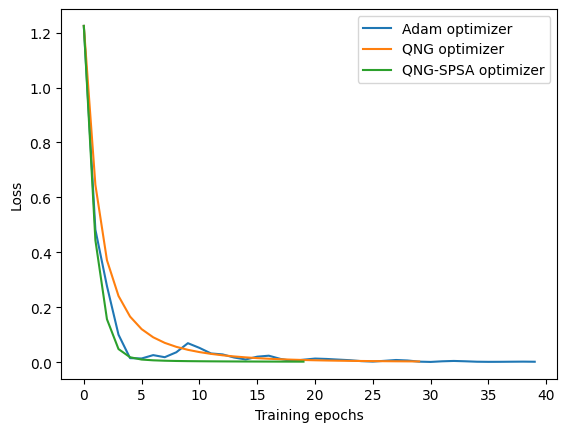

In [9]:
# Plot losses
fig, _ = plt.subplots()
plt.plot(range(n_epochs_adam), loss_adam, label="Adam optimizer")
plt.plot(range(n_epochs_qng), loss_qng, label="QNG optimizer")
plt.plot(range(n_epochs_qng_spsa), loss_qng_spsa, label="QNG-SPSA optimizer")
plt.legend()
plt.xlabel("Training epochs")
plt.ylabel("Loss")
plt.show()